In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,x_max,x_min):
        self.num_points = num_points
        self.x_max = x_max
        self.x_min = x_min
        self.resolution = (x_max-x_min)/num_points
        self.x_data = np.linspace(x_min,x_max,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        #Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1)
        
        #Convert to be on time series
        ts_start = rand_start * (self.x_max - self.x_min - (steps*self.resolution))
        
        #Creat batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        #Create Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        #Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1) , batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1)

In [3]:
ts_data = TimeSeriesData(250,0,10)

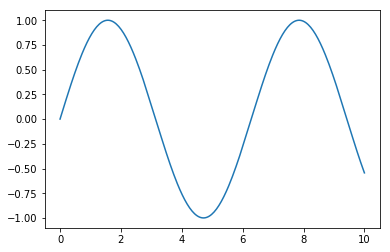

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

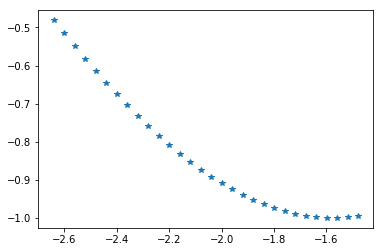

In [14]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

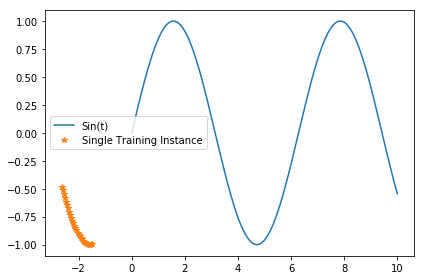

In [15]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

In [16]:
#Training data

In [17]:
train_inst = np.linspace(5,5 + ts_data.resolution*(num_time_steps+1),num_time_steps + 1)

In [18]:
train_inst

array([5.        , 4.95866667, 4.91733333, 4.876     , 4.83466667,
       4.79333333, 4.752     , 4.71066667, 4.66933333, 4.628     ,
       4.58666667, 4.54533333, 4.504     , 4.46266667, 4.42133333,
       4.38      , 4.33866667, 4.29733333, 4.256     , 4.21466667,
       4.17333333, 4.132     , 4.09066667, 4.04933333, 4.008     ,
       3.96666667, 3.92533333, 3.884     , 3.84266667, 3.80133333,
       3.76      ])

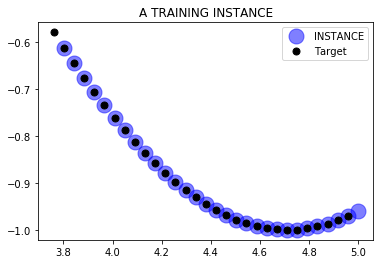

In [22]:
plt.title("A TRAINING INSTANCE")
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='INSTANCE')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize=7,label='Target')
plt.legend()

 ## Creating the Model

In [23]:
tf.reset_default_graph()

In [24]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_interations = 2000
batch_size = 1

In [25]:
#Placeholders
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [26]:
#RNN cell layer

In [27]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
       tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu),
       output_size=num_outputs)

In [28]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [29]:
#MSE
loss = tf.reduce_mean(tf.square(outputs-y))

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [31]:
train = optimizer.minimize(loss)

In [32]:
init = tf.global_variables_initializer()

In [33]:
saver = tf.train.Saver()

In [34]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_interations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,'\tMSE',mse)
            
    saver.save(sess,"./rnn_time_series")

0 	MSE 0.12865314
100 	MSE 0.46731043
200 	MSE 0.06943955
300 	MSE 0.027980955
400 	MSE 0.016287705
500 	MSE 0.039104097
600 	MSE 0.034189474
700 	MSE 0.010979325
800 	MSE 0.0008041418
900 	MSE 0.003621676
1000 	MSE 0.01610356
1100 	MSE 0.015334796
1200 	MSE 0.002911893
1300 	MSE 0.01774813
1400 	MSE 0.019903487
1500 	MSE 0.001590805
1600 	MSE 0.009776449
1700 	MSE 0.011331146
1800 	MSE 0.0077424203
1900 	MSE 0.0009596936


In [36]:
with tf.Session() as sess:
    
    saver.restore(sess,"./rnn_time_series")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series


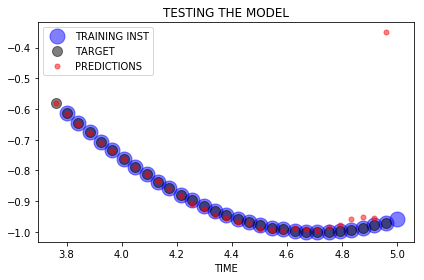

In [37]:
plt.title('TESTING THE MODEL')

#TRAINING INSTANCE
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='TRAINING INST')

#TARGET TO PREDICT
plt.plot(train_inst[1:],np.sin(train_inst[1:]),'ko',markersize=10,alpha=0.5,label='TARGET')

#MODELS PREDICTION
plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize=10,alpha=0.5,label='PREDICTIONS')

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()